# InSituPy demonstration - Analyze data

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import scanpy as sc
from insitupy import read_xenium

## Previous steps

1. Download the example data for demonstration: [01_InSituPy_demo_download_data.ipynb](./01_InSituPy_demo_download_data.ipynb).
2. Register images from external stainings: [02_InSituPy_demo_register_images.ipynb](./02_InSituPy_demo_register_images.ipynb)

At this point, the structure of the data should look like this:

    ```
    ./demo_dataset
    ├───output-XETG00000__slide_id__sample_id
    │   ├───analysis
    │   │   ├───clustering
    │   │   ├───diffexp
    │   │   ├───pca
    │   │   ├───tsne
    │   │   └───umap
    │   └───cell_feature_matrix
    ├───registered_images
    ├───registration_qc
    └───unregistered_images
    ```


## Load Xenium data into `XeniumData` object

Now the Xenium data can be parsed by providing the data path to `XeniumData`

In [3]:
# prepare paths
out_dir = Path("demo_dataset") # output directory
data_dir = out_dir / "output-XETG00000__slide_id__sample_id" # directory of xenium data
image_dir = out_dir / "unregistered_images" # directory of images

In [4]:
xd = read_xenium(data_dir)

In [5]:
xd

XeniumData
Slide ID:	0001879
Sample ID:	Replicate 1
Data path:	demo_dataset
Data folder:	output-XETG00000__slide_id__sample_id
Metadata file:	experiment_modified.xenium

In [6]:
# read all data modalities at once
xd.read_all()

# alternatively, it is also possible to read each modality separately
# xd.read_matrix()
# xd.read_images()
# xd.read_boundaries()
# xd.read_transcripts()
# xd.read_annotations()

Reading annotations...
No `annotations` modality found.
Reading cells...
Reading images...
Reading regions...
No `regions` modality found.
Reading transcripts...


Note: That the `annotations` modality is not found here is expected. Annotations are added in a later step.

In [16]:
xd

XeniumData
Slide ID:	0001879
Sample ID:	Replicate 1
Data path:	demo_dataset
Data folder:	output-XETG00000__slide_id__sample_id
Metadata file:	experiment_modified.xenium
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 167780 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
           varm: 'binned_expression'
       boundaries
           BoundariesData object with 2 entries:
               nuclear
               cellular
    ➤ transcripts
       DataFrame with shape 42638083 x 7

## Working with `InSituPy` project

To allow a simple and structured saving workflow, `InSituPy` provides two saving functions:
- `saveas()`
- `save()`

### Save as `InSituPy` project

In [7]:
insitupy_project = "demo_dataset/demo_insitupy_project"

In [ ]:

xd.saveas(insitupy_project)

### Reload from `InSituPy` project

From the `InSituPy` project we can now load only the modalities that we need for later analyses.

In [8]:
xd = read_xenium(insitupy_project)

In [9]:
xd.read_cells()
xd.read_images()

Reading cells...
	No alternative cells found...
Reading images...


In [10]:
xd

XeniumData
Slide ID:	0001879
Sample ID:	Replicate 1
Data path:	demo_dataset
Data folder:	demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 167780 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
           varm: 'binned_expression'
       boundaries
           BoundariesData object with 2 entries:
               nuclear
               cellular

## Explore data in interactive `napari` viewer

Example image of the viewer:

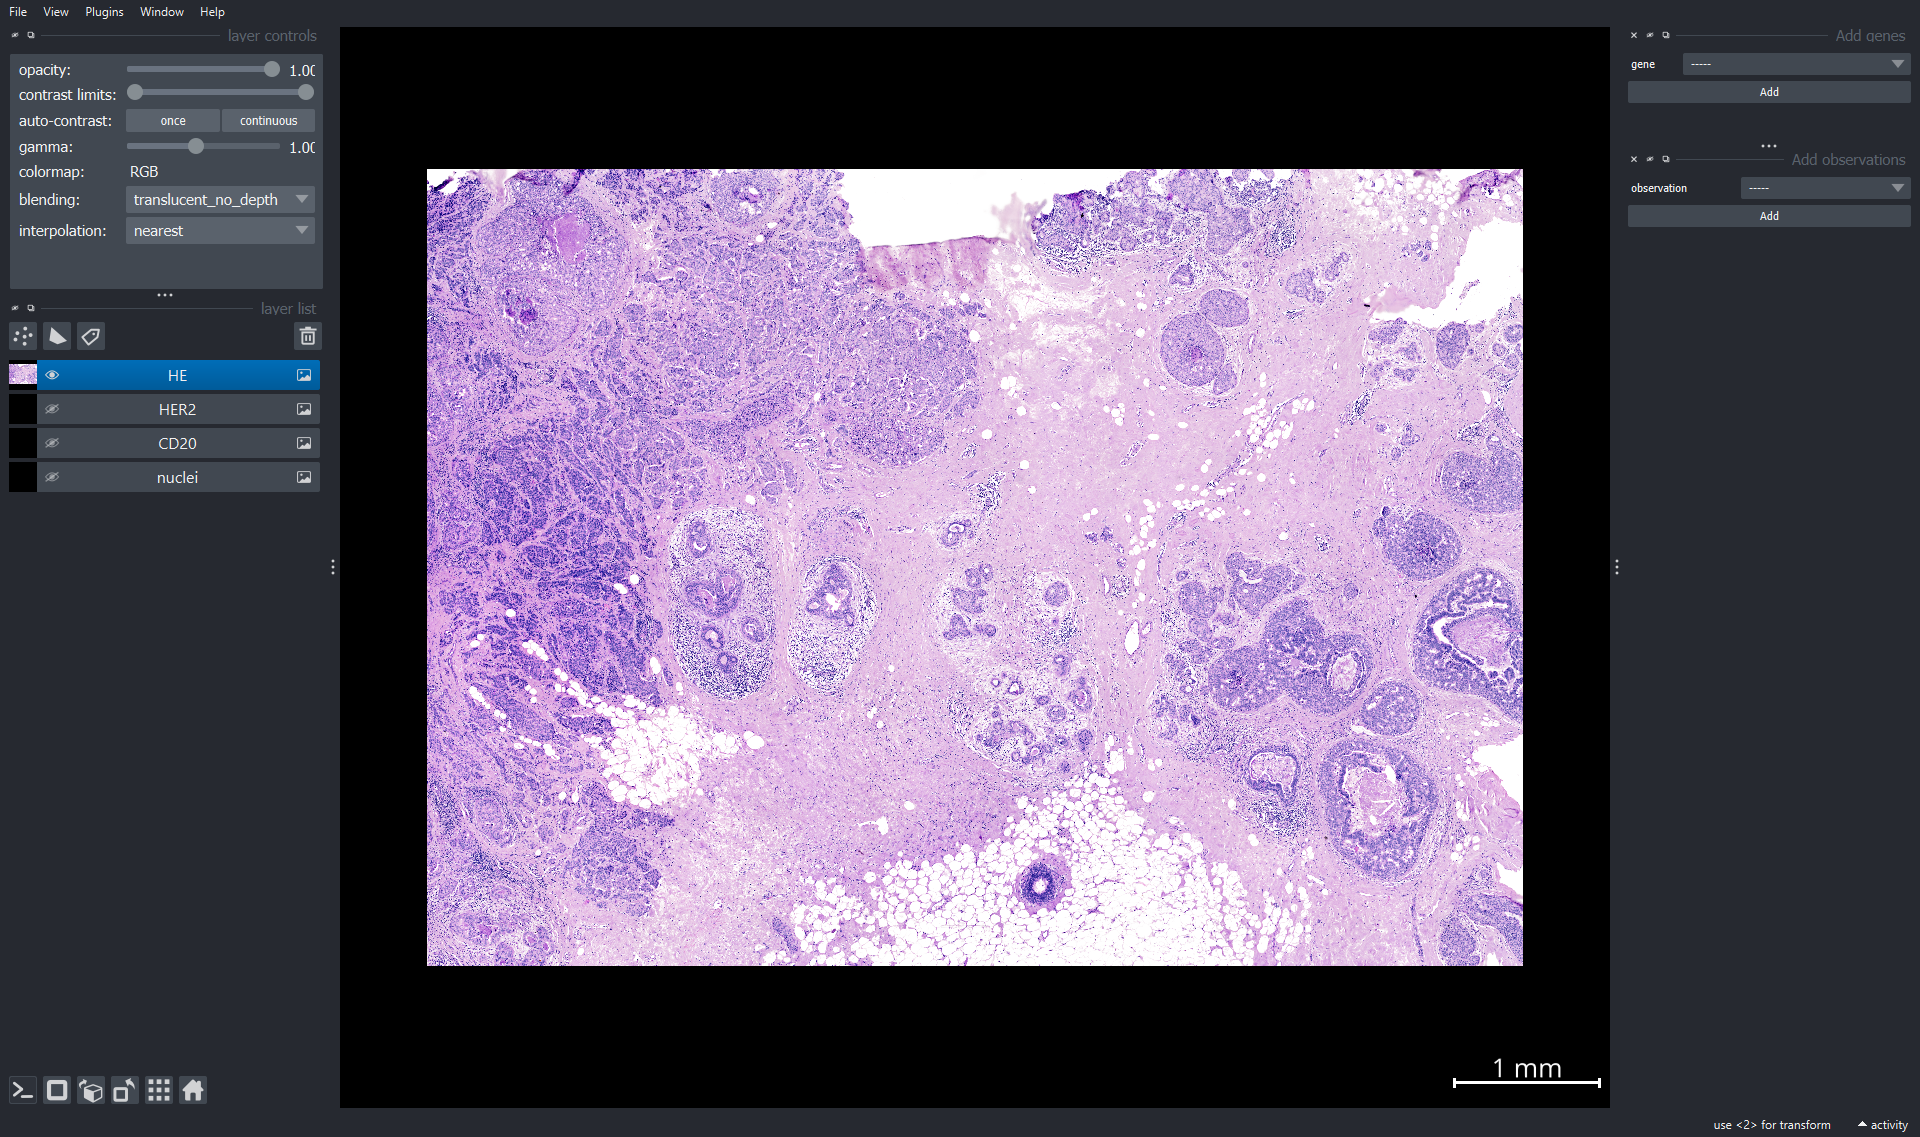

For detailed documentation on the functionalities of `napari` see: https://napari.org/stable/index.html

In [17]:
xd.show()

### Explore gene expression using `napari` viewer

Use the `"Add cells"` widget to explore the single-cell transcriptomic data.

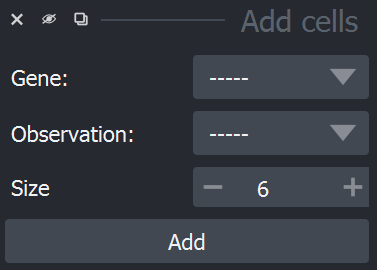

Genes can be selected from the dropdown window by scrolling or by clicking into the window and typing the name of the item:

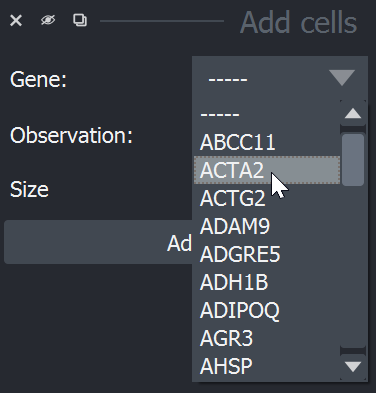

After selection of an item it can be added using the `"Add"` button. The data is added as point layer to the napari viewer.

### Crop data using the `napari` viewer

Steps for cropping:
1. Use the `"New shapes layer"` button to add a new layer of shapes: 

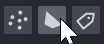

2. Use the `"Add rectangles"` button to select a rectangular region: 

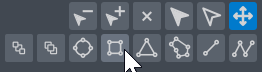

3. Rename the shapes layer or leave the default name `"Shapes"`.
4. Move back to Jupyter Notebook and run `xd.crop()`.

In [18]:
xd_cropped = xd.crop(shape_layer="Shapes")

# alternatively you can also crop using the xlim/ylim arguments
#xd.crop(xlim=(10000,11000), ylim=(12000,14000))

In [19]:
xd_cropped


XeniumData
Slide ID:	0001879
Sample ID:	Replicate 1
Data path:	demo_dataset
Data folder:	demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(7753, 8900)
       CD20:	(7753, 8900)
       HER2:	(7753, 8900)
       HE:	(7753, 8900, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 17244 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
           varm: 'binned_expression'
       boundaries
           BoundariesData object with 2 entries:
               nuclear
               cellular

In [20]:
# show cropped data
xd_cropped.show()

## Perform preprocessing steps

`InSituPy` also includes basic preprocessing functions to normalize the transcriptomic data and perform dimensionality reduction. For normalization, the ``ScanPy`` function `sc.pp.normalize_total()` is used. Data transformation can be either done using logarithmic transformation or square root transformation as suggested [here](https://stlearn.readthedocs.io/en/latest/tutorials/Xenium_PSTS.html).


In [21]:
xd_cropped.normalize(transformation_method="sqrt")
xd_cropped.reduce_dimensions(umap=True, tsne=False)

Store raw counts in anndata.layers['counts']...
Normalization, sqrt-transformation...
Dimensionality reduction...
Leiden clustering...


### Show results using `scanpy` functions

c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


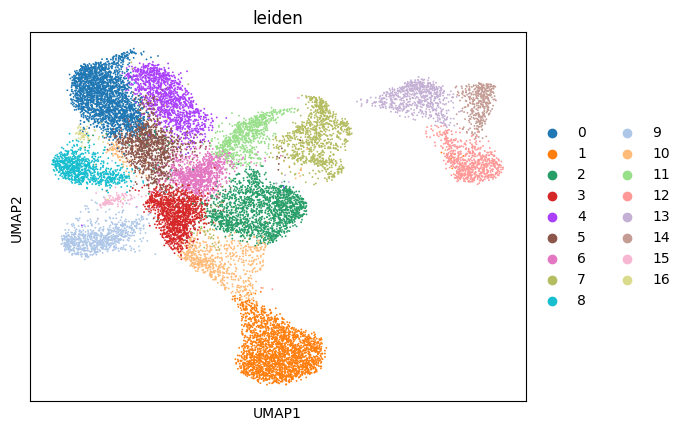

In [22]:
sc.pl.umap(xd_cropped.cells.matrix, color="leiden")

In [23]:
# show cropped data
xd_cropped.show()

#### Start viewer with list of selected genes

Alternatively to selecting genes inside the napari viewer, it is also possible to open the viewer directly including a list of genes.

In [24]:
xd_cropped.show(keys=["leiden", "ACTA2", "LYZ", "LUM"])

Genes can be displayed or hidden via the eye symbol: <br>
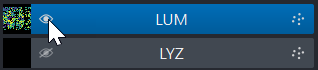

## Save results as `InSituPy` project

The cropped and/or processed data can be saved into a folder using the `.saveas()` function of `InSituData`.

The resulting folder has following structure (can vary depending on which modalities have been loaded before):
```
cropped_processed
│   .ispy
│
├───cells
│   └───uid
│       │   .celldata
│       │
│       ├───boundaries
│       │       cellular.zarr.zip
│       │       nuclear.zarr.zip
│       │
│       └───matrix
│               matrix.h5ad
│
├───images
│       morphology_mip.zarr.zip
│       slide_id__sample_id__CD20__registered.zarr.zip
│       slide_id__sample_id__HER2__registered.zarr.zip
│       slide_id__sample_id__HE__registered.zarr.zip
│
└───transcripts
        transcripts.parquet
```

In [26]:
cropped_dir = out_dir / "cropped_processed"
xd_cropped.saveas(cropped_dir, overwrite=True)

Saving data to demo_dataset\cropped_processed
Saved.


In [27]:
xd_cropped

XeniumData
Slide ID:	0001879
Sample ID:	Replicate 1
Data path:	demo_dataset
Data folder:	demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(7753, 8900)
       CD20:	(7753, 8900)
       HER2:	(7753, 8900)
       HE:	(7753, 8900, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 17244 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'leiden'
           var: 'gene_ids', 'feature_types', 'genome'
           uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
           obsm: 'spatial', 'X_pca', 'X_umap'
           varm: 'binned_expression', 'PCs'
           layers: 'counts', 'norm_counts'
           obsp: 'distances', 'connectivities'
       boundaries
           BoundariesData object with 2 entries:
               nuclear
               cellular

## Reload data

In [28]:
xd_reloaded = read_xenium(cropped_dir)

In [29]:
xd_reloaded

XeniumData
Slide ID:	0001879
Sample ID:	Replicate 1
Data path:	demo_dataset
Data folder:	cropped_processed
Metadata file:	.ispy

In [32]:
xd_reloaded.metadata

{'data': {'images': {'nuclei': 'images/morphology_mip.zarr.zip',
   'CD20': 'images/slide_id__sample_id__CD20__registered.zarr.zip',
   'HER2': 'images/slide_id__sample_id__HER2__registered.zarr.zip',
   'HE': 'images/slide_id__sample_id__HE__registered.zarr.zip'},
  'cells': 'cells/240318-095227958666-3b9077f1',
  'transcripts': 'transcripts/transcripts.parquet'},
 'history': {'cells': ['cells/240318-092917754690-7ab96493'],
  'annotations': [],
  'regions': []},
 'path': 'c:/Users/ge37voy/Github/InSituPy/notebooks/demo_dataset/cropped_processed',
 'metadata_file': '.ispy',
 'uids': ['a97ecae5-297d-43ff-9b19-67c5fcba4f74',
  '48d6d92e-fee9-409a-8612-735946f2cc03'],
 'slide_id': '0001879',
 'sample_id': 'Replicate 1',
 'version': '1.3.0',
 'cropping_history': {'xlim': [[1342.2326896079026, 3233.521038111723]],
  'ylim': [[2028.086359713146, 3675.529355107984]]},
 'xenium': {'run_name': 'PREVIEW: Human Breast Cancer',
  'run_start_time': '',
  'region_name': 'Replicate 1',
  'preservati

In [30]:
xd_reloaded.read_all()

Reading annotations...
No `annotations` modality found.
Reading cells...
	No alternative cells found...
Reading images...
Reading regions...
No `regions` modality found.
Reading transcripts...


FileNotFoundError: [Errno 2] No such file or directory: 'demo_dataset\\cropped_processed\\transcripts\\transcripts.parquet'

# Problem: We loaded transcripts in the beginning and saved the insitupy project with the transcripts. During saving the transcripts path was saved into the metadata but it is not deleted when the data is later reloaded and transcripts are not loaded.

## Solution
- Different strategy on how the metadata file is used
- Should it be generated during loadig or during saving?
- Currently it is essential for reading the data. Should it be used differently?

In [21]:
xd_reloaded

XeniumData
Slide ID:	slide_id
Sample ID:	sample_id
Data path:	demo_dataset
Data folder:	cropped_processed
Metadata file:	.xeniumdata
    ➤ images
       nuclei:	(3065, 3171)
       CD20:	(3065, 3171)
       HER2:	(3065, 3171)
       HE:	(3065, 3171, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 2557 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'leiden'
           var: 'gene_ids', 'feature_types', 'genome'
           uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
           obsm: 'X_pca', 'X_umap', 'spatial'
           varm: 'PCs'
           layers: 'counts', 'norm_counts'
           obsp: 'connectivities', 'distances'
       boundaries
           BoundariesData object with 2 entries:
               cellular
               nuclear
    ➤ transcripts
       DataFrame with shape 625218 x 8

In [23]:
xd_reloaded.show()